Imports

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
from keras_cv import visualization
import tqdm
import xml.etree.ElementTree as ET
import tensorflow as tf
import requests
import zipfile

from tqdm.auto import tqdm
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization

In [3]:
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('data.zip')

Extracted all


In [5]:
data_dir = 'data'
file_list = os.listdir(data_dir)
print(file_list)

['images', 'annotations']


Dataset and Training Parameters

In [6]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 8
LEARNING_RATE = 0.0001
EPOCH = 75
GLOBAL_CLIPNORM = 10.0
IMG_SIZE = (640, 640)

Dataset Preparation

In [7]:
class_ids = [
    "Waldo"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "data/images/"
path_annot = "data/annotations/"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

In [8]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/47 [00:00<?, ?it/s]

In [9]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [10]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [11]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [12]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        # keras_cv.layers.RandomGaussianBlur(kernel_size=(3, 3), factor=(0.5, 0.5)),
        # keras_cv.layers.RandomBrightness(factor=(0.5, 0.5)),
        # keras_cv.layers.RandomContrast(value_range=(0, 255), factor=(0.1, 0.9)),
        keras_cv.layers.JitteredResize(
            target_size=IMG_SIZE,
            scale_factor=(0.75, 1.3),
            bounding_box_format="xyxy",
        ),
    ]
)

In [13]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
resizing = keras_cv.layers.JitteredResize(
    target_size=IMG_SIZE,
    scale_factor=(1.0, 1.0),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

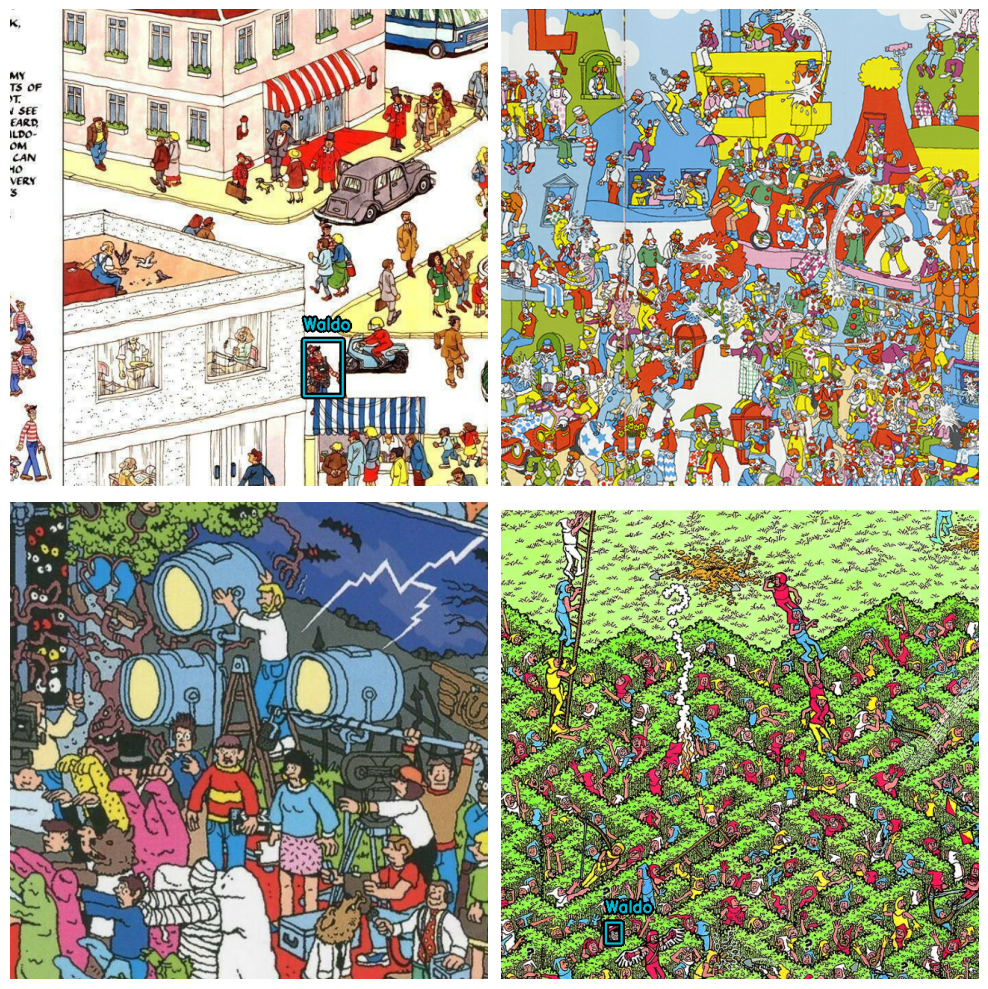

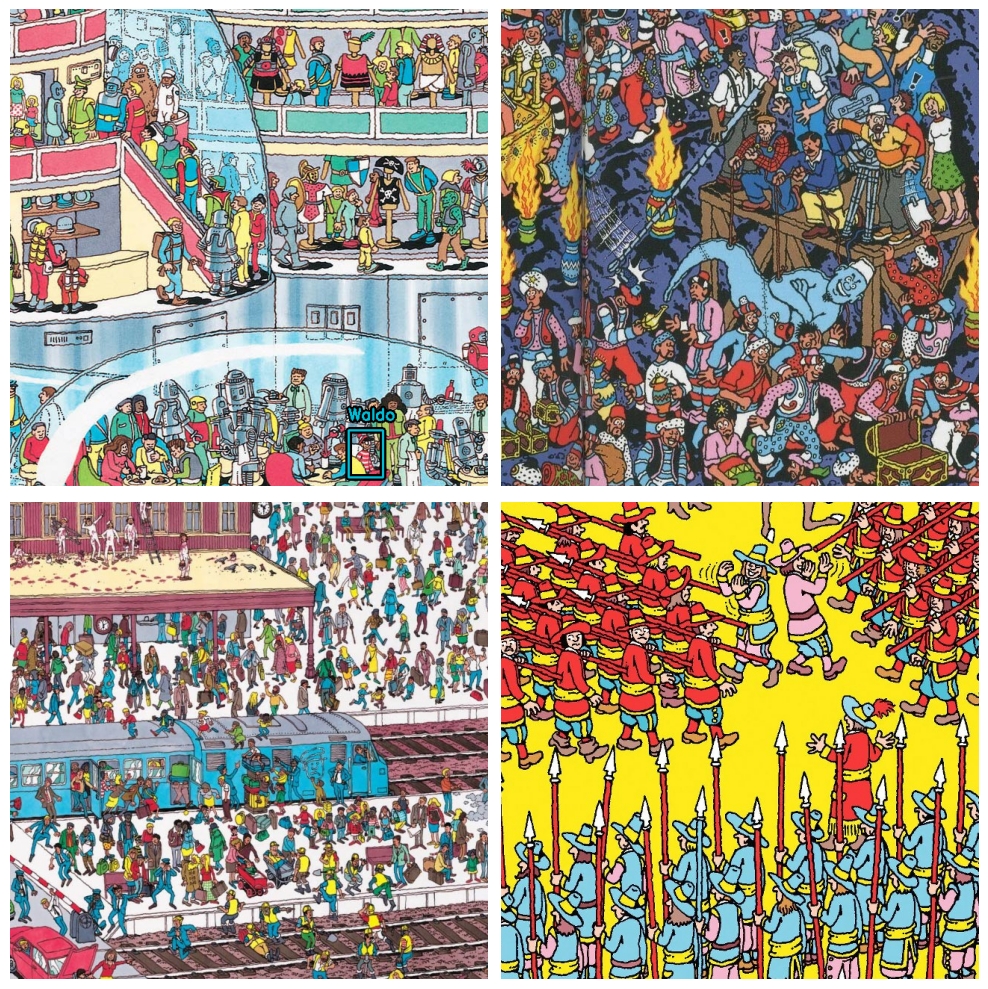

In [15]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [16]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

YOLOv8 Model

In [17]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_l_backbone_coco",
    load_weights=True
)

79778896/79778896 [==============================] - 6s 0us/step


In [18]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=3,
)

In [19]:
yolo.summary()

Model: "yolov8_detector"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model (Functional)          {'P3': (None, None, None,    1983174   ['input_2[0][0]']             
                             256),                        4                                       
                              'P4': (None, None, None,                                            
                             512),                                                                
                              'P5': (None, None, None,                                            
                             512)}                                                  

In [20]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

Evaluation Metrics

In [21]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

Tensorboard Callback

In [22]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs_yolov8large")

Training

In [ ]:
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=[
        EvaluateCOCOMetricsCallback(val_ds, "model_yolov8large.h5"),
        tensorboard_callback
    ],
)

Epoch 1/75
4/4 [==============================] - ETA: 0s - loss: 10283.9971 - box_loss: 5.2416 - class_loss: 10278.7559WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


/Users/fabian/.pyenv/versions/3.10.6/envs/wheres_waldo/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 92s 18s/step - loss: 10283.9971 - box_loss: 5.2416 - class_loss: 10278.7559 - val_loss: 0.0000e+00 - val_box_loss: 0.0000e+00 - val_class_loss: 0.0000e+00 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 2/75
4/4 [==============================] - 65s 16s/step - loss: 6548.0591 - box_loss: 5.4340 - class_loss: 6542.6260 - val_loss: 9016.1104 - val_box_loss: 6.3900 - val_class_loss: 9009.7207 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[m

Inference on Validation Images using the Trained Model